# _Addendum to tutorial "A Mitigation-Reassignment Protocol ":_

## _Three-Sided Dice Model and Preserved Coherence  Applying the Protocol to a Four-Qubit Not Fully Entangled State_

## Introduction:



A three-sided dice construction by quantum computing mitigation-reassignment (QCMR) is possible, but experience shows that the protocol effectiveness is hampered by the fact that the illegal result set is reduced to 5 elements.

Here you will examine a solution consisting of applying the protocol to a not fully entangled state of four qubits:
 
$$ \mid Q \rangle = \mid{0}\rangle \frac{\mid{001} \rangle + \mid{010} \rangle + \mid{100} \rangle}{\sqrt{3}}$$.

$Q_{ideal}$ becomes ('0001', '0010', '0100') with probability $\frac {1}{3}$ for each result.

The result "1000" joins the illegal set which now includes 13 elements.

The creation circuit is now obtained by vector initialization. A 64 id gates delay time between state creation and measurement has been added in the example presented here.

Otherwise, the program remains largely unchanged and comments have been limited. Please refer to main tutorial.

In [1]:
import numpy as np
import time
import itertools
from operator import itemgetter
import copy
import pprint
import operator

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.providers.aer import noise
from qiskit.tools.visualization import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import qiskit.tools.jupyter

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q')

## Determine the backend

Here is the listing of the backends that you can access on line with your own account: 


In [4]:
backends = provider.backends()
backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

## Backend overview
To make your choice, a good idea is to have a look at the queue for the different devices 

In [5]:
%qiskit_backend_overview

## Determine the backend

Enter here the name of the backend of your choice.

In [143]:
# determine here the backend
backend = provider.get_backend('ibmqx2') # the backend names are listed here above
backend.status()

BackendStatus(backend_name='ibmqx2', backend_version='2.0.1', operational=True, pending_jobs=3, status_msg='active')

## Establish the layout qubit list

Once the backend is chosen, you will now select four physical qubits with names $Q0$, $Q1$, $Q2$, $Q3$. The following cell will do the work for you.

In [7]:
# Determine the qubit Q_list layout
# The four qubits at the head of the list are the selected ones
# The remaining qubits are neither part of the entangled state nor of the mitigation calibration but must be listed

total_qubits = 5
Q_list = [0,1,3,4,2] # one out of four options for ourense, london, essex

if backend.name() == 'ibmqx2':
    Q_list = [4,3,2,0,1]  # one out of many options for yorktown
    
if backend.name() == 'ibmq_vigo':
    # best for vigo: deep circuit 
    Q_list = [0,1,2,3,4]

if backend.name() == 'ibmq_burlington':
    Q_list = [0,1,2,3,4]  # same option as for vigo - deep circuit

if backend.name() == 'ibmq_16_melbourne':
    Q_list = [13,1,2,3,0,4,5,6,7,8,9,10,11,12] # unique "straight" layout for melbourne
    total_qubits = 14
    
qr = QuantumRegister(total_qubits)   
print("backend:", backend.name(), "Q_list:", Q_list, "total qubits:",total_qubits )

backend: ibmqx2 Q_list: [4, 3, 2, 0, 1] total qubits: 5


## Decide if mitigation will happen before reassignment

Set mitigation boolean variable to True for exploring the complete QCMR protocol (mainstrean option).

If you are in a hurry, set mitigation to False. You will bypass the 16 circuits job of mitigation calibration and explore the effect of reassignment alone.

In [178]:
mitigation = True # The mainstream choice is True. Set to False if mitigation is not wanted. 

## Obtain the mitigation filter

This section follows the procedures explained in this [tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/4_measurement_error_mitigation.ipynb).

In short, you will generate a list of $2^4=16$ measurement calibration circuits given they are four qubits in layout list.

In [9]:
if mitigation:
    meas_calibs, state_labels = complete_meas_cal(qubit_list=Q_list[0:4], qr=qr, circlabel='mcal')

Then you execute the 16 circuits:

In [10]:
if mitigation:  
    nb_shots_cal = 8192 # set here the number of shots for the testing phase

In [11]:
if mitigation:
    job_cal = execute(meas_calibs, backend=backend, shots=nb_shots_cal)
    print(job_cal.job_id())
    job_monitor(job_cal)
    time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
    print("DMY: ",time_exp)
    cal_results = job_cal.result()

5ded68503ccc1e0013b109bc
Job Status: job has successfully run
DMY:  08/12/2019 22:20:14


And finally you obtain the mitigation measurements filter:

In [12]:
if mitigation:
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=Q_list[0:4], circlabel='mcal')
    meas_filter = meas_fitter.filter

Have a look at the average measurement fidelity calculated as the trace of the calibration matrix.

In [13]:
if mitigation:
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.914314


## Create the quantum state

Unlike in the main tutorial, here you will use vector initialization.

In [170]:
# define the distribution and create the quantum state

p0 = 1.0/3.0
p1 = 1.0/3.0
p2 = 1.0/3.0
p3 = 0.0

Q_state = QuantumCircuit(4, 4)
desired_vector = [0, np.sqrt(p0), np.sqrt(p1), 0, np.sqrt(p2), 0, 0, 0, np.sqrt(p3), 0, 0, 0, 0 ,0 , 0, 0]  
Q_state.initialize(desired_vector, [0,1,2,3])

## Set the delay time

Here you can set the delay time beween state creation and measurement, in units equal to an identity gate operation time, which varies from device to device.


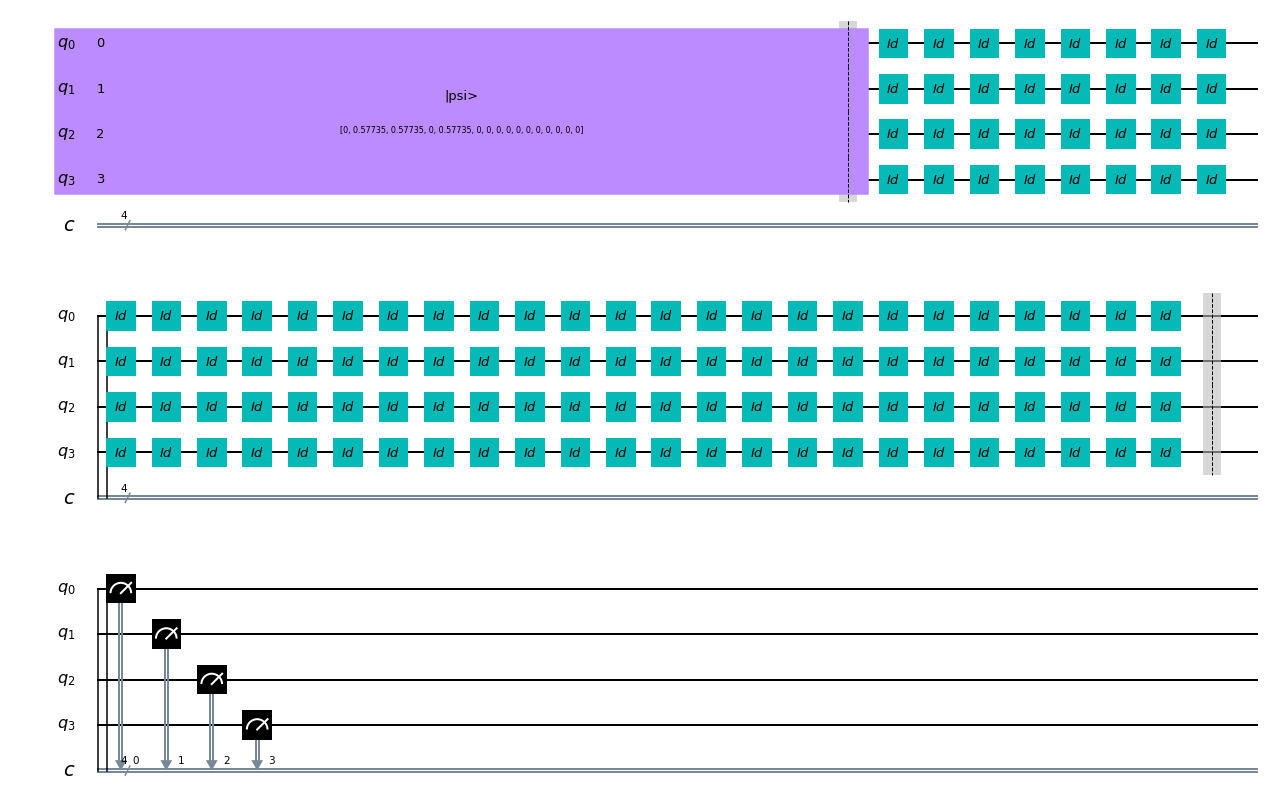

In [171]:
n_id = 32               

if n_id > 0:
    Delay_time = QuantumCircuit(4, 4)
    Delay_time.barrier();
    for i in range(n_id):
        for j in range(4):
            Delay_time.iden(j)
            
Measure = QuantumCircuit(4, 4)
Measure.barrier()
for j in range(4):
    Measure.measure(j,j)

if n_id > 0:
    Q_state_final = Q_state + Delay_time + Measure
elif n_id == 0:
    Q_state_final = Q_state + Measure
    
Q_state_final.draw(output='mpl')

## Get the optimized version of the circuit

backend: ibmqx2  initial_layout: [4, 3, 2, 0, 1]
depth =  78
gates =  OrderedDict([('id', 128), ('cx', 38), ('u3', 14), ('measure', 4), ('barrier', 2)])


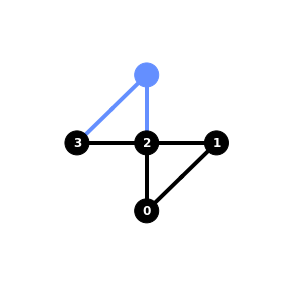

In [172]:
print("backend:", backend, " initial_layout:", Q_list)
Q_state_opt = transpile(Q_state_final, backend=backend, seed_transpiler=1, optimization_level=1, initial_layout=Q_list)
print('depth = ', Q_state_opt.depth())
print('gates = ', Q_state_opt.count_ops())
plot_circuit_layout(Q_state_opt, backend)

## Have a look at the optimized circuit before verification

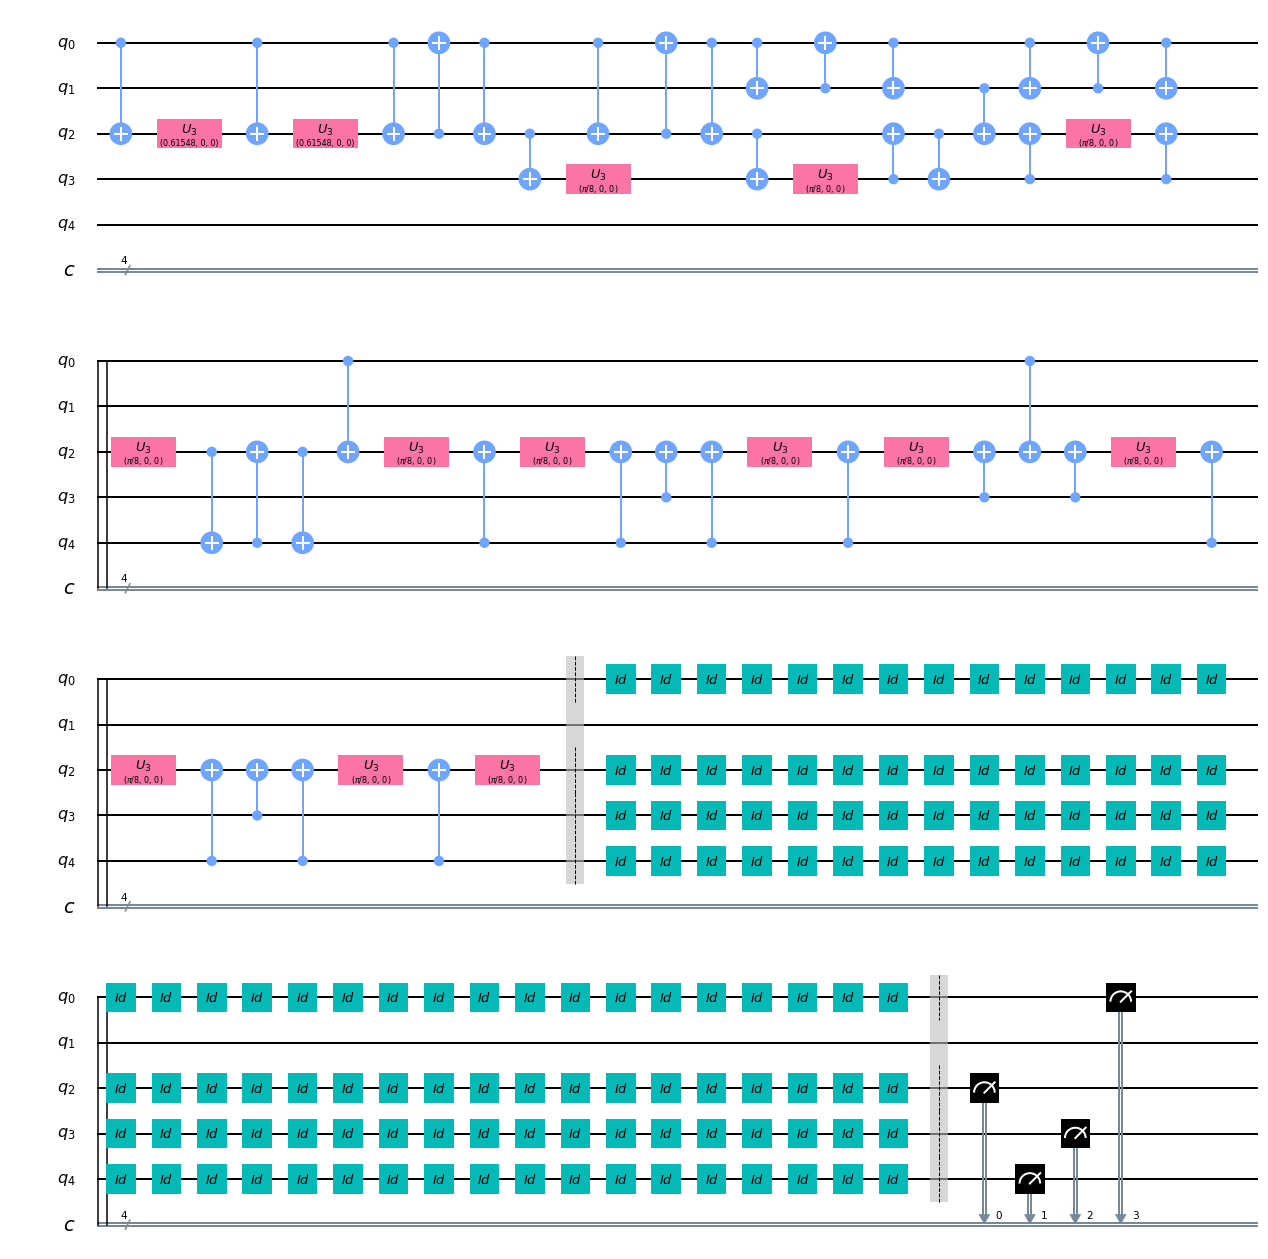

In [173]:
Q_state_opt_basis =  Q_state_opt.decompose()
Q_state_opt_basis.draw(output='mpl')

## Verify the circuit on a noise-free simulator

It's always a good precaution.

Expected result set: {'0100': s_sim/3, '0010': s_sim/3, '0001': s_sim/3}

{'0010': 2715, '0001': 2704, '0100': 2773}


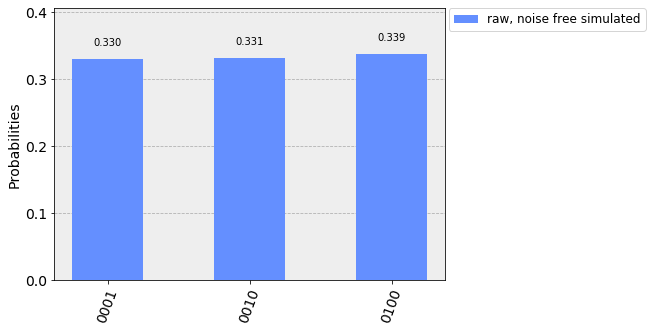

In [175]:
# Determine the simulator for circuit verification
simulator = Aer.get_backend('qasm_simulator')  
s_sim = 8192   
# Proceed to the verification
job = execute([Q_state_opt], backend=simulator, shots=s_sim)
results_sim = job.result()
raw_counts_sim = results_sim.get_counts()
print(raw_counts_sim)
plot_histogram(raw_counts_sim, legend=['raw, noise free simulated'])

## Obtain the training raw counts

In [150]:
nb_shots = 8192 # set here the number of shots for the training phase

In [151]:
# execute the circuit
job = execute([Q_state_opt], backend=backend, shots=nb_shots)
print(job.job_id())
job_monitor(job)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp)
results = job.result()

5dedf3df6070520012253057
Job Status: job has successfully run
DMY:  09/12/2019 08:14:27


In [152]:
# Before obtaining and treating measurement data,
# make sure that the generated dictionaries will end with a complete set of keys

total_state_labels_list = ['0000','0001','0010','0011','0100', '0101', '0110', '0111',
                   '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
void_counts = dict(zip(total_state_labels_list, np.zeros(16, dtype=int)))

raw_counts = copy.deepcopy(void_counts)
raw_counts_test = copy.deepcopy(void_counts)
m_counts = copy.deepcopy(void_counts)
mct = copy.deepcopy(void_counts)

In [153]:
# Results without mitigation
raw_counts.update(results.get_counts())
print(raw_counts)

{'0000': 740, '0001': 1672, '0010': 2334, '0011': 391, '0100': 1181, '0101': 408, '0110': 193, '0111': 215, '1000': 257, '1001': 90, '1010': 257, '1011': 81, '1100': 174, '1101': 67, '1110': 72, '1111': 60}


## Obtain the test raw counts 
 

In [154]:
nb_shots_test = 8192 # set here the number of shots for the testing phase

In [155]:
# run the circuit

time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp) 
job = execute([Q_state_opt], backend=backend, shots=nb_shots_test)
print(job.job_id())
job_monitor(job)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp)   
results_test = job.result()  

DMY:  09/12/2019 08:14:28
5dedf456f9ea0b0012990b83
Job Status: job has successfully run
DMY:  09/12/2019 08:16:06


In [156]:
# Test results without mitigation
raw_counts_test.update(results_test.get_counts())
print(raw_counts_test)

{'0000': 707, '0001': 1693, '0010': 2365, '0011': 389, '0100': 1178, '0101': 382, '0110': 188, '0111': 223, '1000': 255, '1001': 81, '1010': 239, '1011': 92, '1100': 177, '1101': 62, '1110': 91, '1111': 70}


## ("Rerun without mitigation" point)

After completing QCMR, here is to restart (Cell - Run All Below) after setting the boolean variable "mitigation" to False for a rerun without prior mitigation.

## Look at the training results 

In [179]:
# (with remediation to the plot_histogram not displaying issue of Qiskit)
if mitigation:
    mitigated_results = meas_filter.apply(results, method = 'least_squares')
    m_counts.update(mitigated_results.get_counts(0))
    legend2 = "mitigated (training)"
    color2 = "m"
else:
    m_counts = raw_counts.copy()
    legend2 = "(no mitigation)"
    color2 = "c"
    
print(m_counts)

{'0000': 601.0044132304017, '0001': 1747.5128999292444, '0010': 2443.2509255305813, '0011': 372.45774205902256, '0100': 1228.756942678102, '0101': 406.1865643363661, '0110': 163.52115138103142, '0111': 213.4555912721425, '1000': 248.0174933137459, '1001': 73.53824010634833, '1010': 246.44628245534, '1011': 79.4257579238918, '1100': 169.67049923963623, '1101': 65.76016714361683, '1110': 70.80749810232251, '1111': 62.187831298205865}


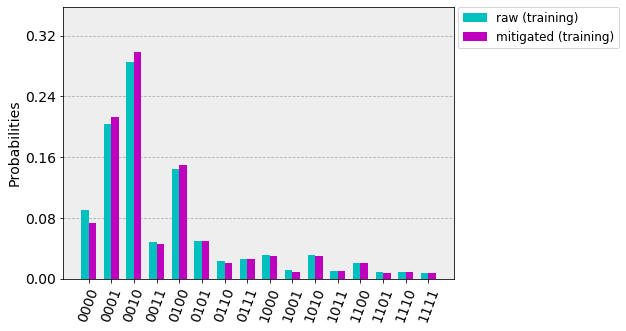

In [180]:
plot_histogram([raw_counts, m_counts], legend=['raw (training)', legend2],bar_labels=False, color=("c",color2))

## Reassignment procedure

Now you will reassign the probabilities observed for the illegal result set to items of the legal set.
 
There are now $3^{13}$ possible combinations for the reassignment.The metric ($SED$) and the optimization method are unchanged.

Ready for finding the best combination with the lower SED? This will take less time than in the main tutorial case (less than a minute on most systems).
 
(Note that connecting your laptop to the ac adapter rather than staying on battery can sometimes reduce the runtime by more than half)

In [181]:
# find the best combination
Q_dist = np.array([p0, p1, p2]) # ideal distribution

add_counts = np.array([m_counts['0000'], m_counts["0011"], m_counts["0101"], m_counts["0110"],
                    m_counts["0111"], m_counts["1000"], m_counts['1001'], m_counts["1010"], m_counts["1011"],
                    m_counts["1100"], m_counts['1101'], m_counts["1110"], m_counts["1111"]])/nb_shots

new_sums_start = np.array([m_counts["0001"],m_counts["0010"],
                           m_counts["0100"]])/nb_shots

pmq_start = np.subtract(new_sums_start, Q_dist)

SED = 2 # set starting maximal value for squared euclidean distance.

print("Start combinations",time.strftime('%d/%m/%Y %H:%M:%S'))            
time_start = time.time()

for combi in itertools.product(range(3),repeat = 13):   #  cartesian product, equivalent to a nested for-loop 
    
    pmq = pmq_start.copy()
    for i,v in enumerate(combi):   
        pmq[v] += add_counts[i]
    
    SED_new = np.dot(pmq , pmq)
    
    if SED_new <= SED:
        SED = SED_new
        combi_test = combi

print("performed in ",round((time.time()-time_start)/60,3),"min")

Start combinations 09/12/2019 10:35:15
performed in  0.226 min


## A look at the training results after reassignment

In [182]:
print("SED (training):", "%.6E" % SED, "for selected combination:", combi_test, "mitigation:", mitigation)

new_sums_selected = new_sums_start.copy()   
for i,v in enumerate(combi_test):   
            new_sums_selected[v] += add_counts[i]

legal_state_labels_list = ['0001', '0010', '0100']
prob_dict1 = dict(zip(legal_state_labels_list, new_sums_selected))

print(prob_dict1)

SED (training): 6.130853E-09 for selected combination: (0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 2, 0, 0) mitigation: True
{'0001': 0.33332628170455353, '0010': 0.333281830677377, '0100': 0.3333918876180695}


## Training phase synthesis 

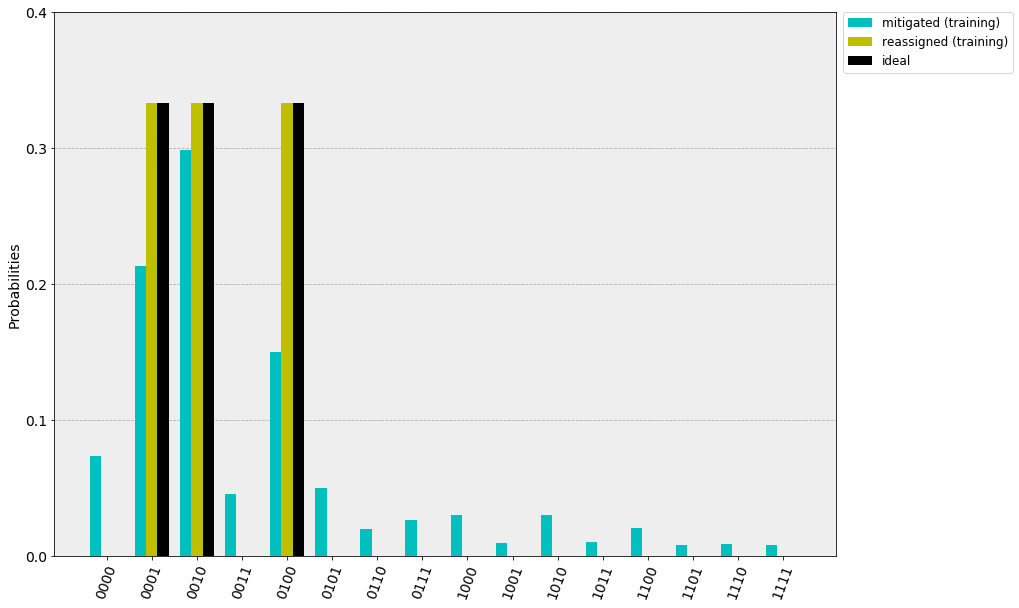

In [183]:
ideal_counts = {'0000':0.0, '0001':p0, '0010':p1, '0011':0.0,
                 '0100':p2, '0101':0.0, '0110':0.0, '0111':0.0,
                 '1000':p3 , '1001':0.0, '1010':0.0, '1011':0.0,
                 '1100':0.0, '1101':0.0, '1110':0.0, '1111':0.0}
illegal_state_labels_list = ['0000', '0011', '0101', '0110', '0111', '1000',
                   '1001', '1010', '1011', '1100', '1101', '1110', '1111']
prob_dict2 = dict(zip(illegal_state_labels_list, np.zeros(12)))
prob_dict= {**prob_dict1, **prob_dict2}
legend1 = "raw (training)"
color1 = "c"
if mitigation:
    legend1 = "mitigated (training)"
    color1 = "m"
plot_histogram([m_counts, prob_dict, ideal_counts],
                legend=[legend1, "reassigned (training)","ideal"],
                figsize=(14, 10),bar_labels=False, color=("c","y","k"))

## Create the mapping table

Let's create a dictionary relating the sixteen possible results to the three dice outcomes (1, 2, 3).

In [184]:
# create the dictionary

dice_values_list1 = [1,2,3]
dice_dict1 = dict(zip(legal_state_labels_list, dice_values_list1))
dice_values_list2 = []
for i,v in enumerate(combi_test):
    dice_values_list2.append(v+1)
dice_dict2 = dict(zip(illegal_state_labels_list, dice_values_list2))
dice_dict= {**dice_dict1, **dice_dict2}

## Throw the dice

You have now completed the making of the three-sided quantum dice. 

Suppose you make a one shot experiment and you get a four bit result in the classical registers.

Run the following cell to see to which dice outcome it corresponds.

In [190]:
# throw the dice
key_side = "1000" # indicate here your result
print("dice value is",  dice_dict[key_side], "for result", key_side)

dice value is 3 for result 1000


## Look now at the test results

In [191]:
# (with remediation to the plot_histogram not displaing issue of Qiskit)
if mitigation:
    mit_results_test = meas_filter.apply(results_test, method = 'least_squares')
    mct.update(mit_results_test.get_counts(0))
    legend2 = "mitigated (test)"
    color2 = "m"
else:
    mct = raw_counts_test.copy()
    legend2 = "(no mitigation)"
    color2 = "c"
    
print(raw_counts_test)
if mitigation:
    print(mct)

{'0000': 707, '0001': 1693, '0010': 2365, '0011': 389, '0100': 1178, '0101': 382, '0110': 188, '0111': 223, '1000': 255, '1001': 81, '1010': 239, '1011': 92, '1100': 177, '1101': 62, '1110': 91, '1111': 70}
{'0000': 564.8443012276675, '0001': 1771.5953839658123, '0010': 2477.4797041623915, '0011': 369.0702892911973, '0100': 1226.5424482534345, '0101': 377.9633221895814, '0110': 157.0057123254181, '0111': 222.10571747629896, '1000': 247.24217650056028, '1001': 63.215461361840234, '1010': 225.23179563231167, '1011': 91.63635250772269, '1100': 172.64186645534852, '1101': 60.10003617815585, '1110': 91.94284484771399, '1111': 73.38258762454547}


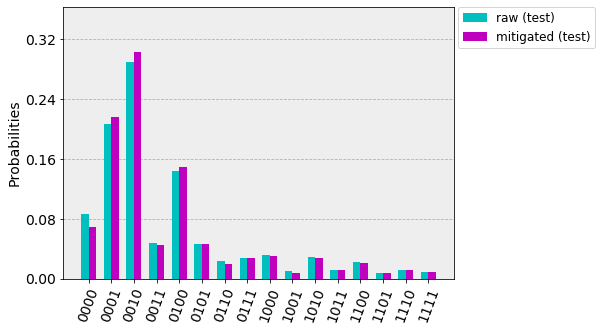

In [187]:
plot_histogram([raw_counts_test, mct], legend=['raw (test)', legend2],bar_labels=False, color=("c",color2))

##  Reassignment procedure for the test results

You will proceed to the reassignment by applying the best combination determined at training. 

In [188]:
add_counts_test =  np.array([mct['0000'], mct["0011"], mct["0101"], mct["0110"],
                  mct["0111"], mct['1000'], mct['1001'], mct["1010"], mct["1011"],
                  mct["1100"], mct['1101'], mct["1110"], mct["1111"]])/nb_shots_test
                
new_sums_test = np.array([mct["0001"], mct["0010"], mct["0100"]])/nb_shots_test   
    
for i,v in enumerate(combi_test):   
    new_sums_test[v] += add_counts_test[i]

pmq_test = np.subtract(new_sums_test, Q_dist) 
SED_test = np.dot(pmq_test , pmq_test)

print("SED (test):", "%.6E" % SED_test , "for selected combination:", combi_test, "mitigation:", mitigation)

prob_dict1_test = dict(zip(legal_state_labels_list, new_sums_test))
print(prob_dict1_test)

SED (test): 1.019513E-04 for selected combination: (0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 2, 0, 0) mitigation: True
{'0001': 0.33765177442371586, '0010': 0.3372559672692254, '0100': 0.3250922583070589}


## Test phase synthesis

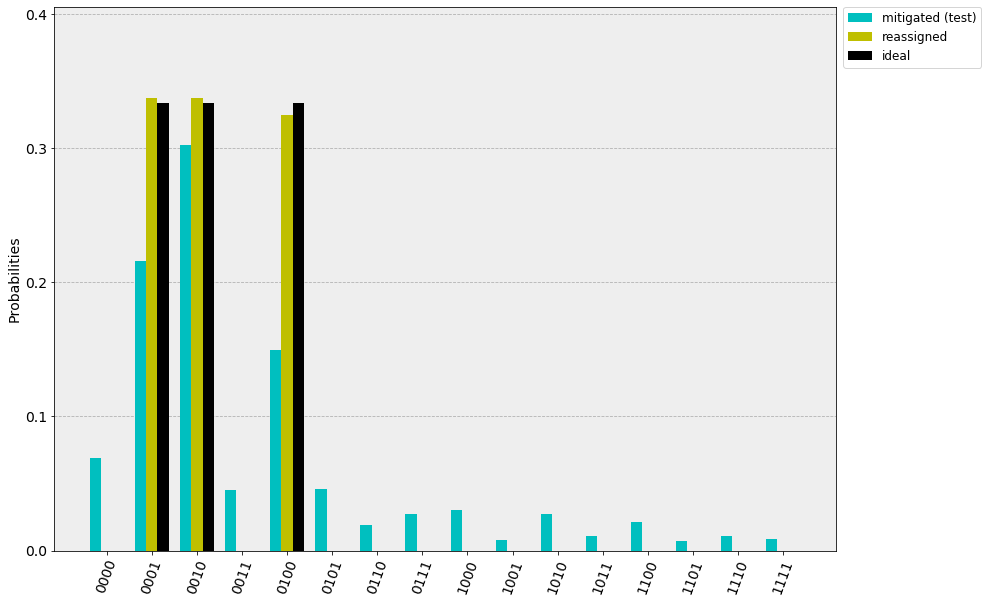

In [189]:
prob_dict_test= {**prob_dict1_test, **prob_dict2}
legend1 = "raw (test)"
color1 = "c"
if mitigation:
    legend1 = "mitigated (test)"
    color1 = "m"
plot_histogram([mct, prob_dict_test, ideal_counts],
                legend=[legend1, "reassigned","ideal"],
                figsize=(14, 10),bar_labels=False, color=("c","y","k"))

### Addendum

##### Want to try a reassignment process without prior mitigation?

In this case, execute the next cell and return to the cell "("Rerun without mitigation" point)" here above.

In [168]:
mitigation = False # run this cell if mitigation is wanted, then back to "("Rerun without mitigation" point)"

In [169]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright